# Understanding GCN from a GSP perspective

GCN(Graph Convolution Network) 是一个经典的图神经网络模型，在半监督节点分类等任务上取得了巨大的成功。GCN 的一个重要贡献在于，将传统 CNN 中的对 grid-like 数据的卷积运算，推广到了图这种非 grid-like 的结构化数据上。但 GCN 中的卷积到底是怎么一回事？和传统信号处理中的卷积、傅里叶变换、滤波器等概念能否对应起来？

## 预备知识：传统信号处理
传统的信号是一个关于时间的函数 $x(t)$，因此也称为信号在时域上的表示。它表示这个信号随着时间如何变化，对人类而言比较容易理解。

如果该信号满足一定的条件，它可以通过傅里叶变换得到其在频域上的表达。它表示这个信号由在各组基（这里是傅里叶基，正弦与余弦信号）下的分量。

![傅里叶变换](./pictures/fourier.png)

如上图所示，时域上的一个信号，可以分解为多个余弦信号的叠加。

假设 $x(t) = \cos(x) + 0.5 \cos(2x) + 0.2 \cos(3x)$，那么信号 $x(t)$ 在频域下的表达就是：$[0, 0, 1, 0, 0.5, 0, 0.2, 0, \ldots ]$，系数分别对应常数项，$\sin(x)$，$\cos(x)$，$\sin(2x)$，$\cos(2x)$，... 上的分量大小（也称幅度）。

了解了傅里叶变化，我们再来说说卷积和滤波。卷积是两个信号间的一种运算，（在时域上）以积分的形式定义。

积分的运算很麻烦，好在傅里叶变换有个好性质，时域上的卷积等价于频域上的乘积，这样就把复杂的积分运算简化成了简单的乘积运算。

假如信号 $x_1(t) = 1.5\sin(x) + 0.5\cos(x) + 1.5\sin(2x)$，$x_2(t) = 0.5\sin(x) + 0.5\cos(x) + 1.5\cos(2x)$，卷积的结果就是 $x_1 * x_2 (t) = 0.75 \sin(x) + 0.25 \cos(x)$。可以看到，卷积结果中各个频率分量是两个分量的乘积。

滤波是什么意思呢，就是用一个特定的信号和已有信号做卷积，达到特定的目的。如低通滤波，功能是抑制高频分量，那么低通滤波器信号中，高频分量的幅度就会很小，相乘之后高频分量的幅度也相应减小，以此达到抑制高频的目的。

## 图信号处理


介绍完了预备知识，现在开始讲图信号处理(Graph Signal Processing, GSP)的相关知识。假设图 $G=(V, E)$ 拥有 $n=|V|$ 个节点，那么图上的信号 $x$ 就定义为一个 $\mathbb{R}^{n}$ 上的向量，$x$ 的第 $i$ 个分量 $x(i)$ 就相当于在第 $i$ 号节点上的值。这里，图上的节点相当于传统时域信号中的时间点，只不过传统信号是线性序的，时间之间有固定的先后顺序。图是一个结构化的数据，节点之间没有明显的先后顺序，是通过图结构相关联的，这也是处理图数据时的一个难点。因此，传统信号中的时域(time domain)，在图上称为“空域”(spatial domain)，即代表信号在图定义的拓扑结构上的分布。

同样，通过傅里叶变换，我们可以将空域信号转换成频域信号，为此，我们需要找到一组基。GSP 中采用的基一般是拉普拉斯矩阵的特征向量。拉普拉斯矩阵是半正定阵，有 $n$ 个正交的特征向量，正好能构成 $\mathbb{R}^n$ 的一组基，这些基就类似传统信号中的正弦、余弦函数。拉普拉斯矩阵的特征值即频率。

假定拉普拉斯矩阵可以分解为：
$$ L = U \Lambda U^\mathrm{T}$$
，特征向量为 $u_1, u_2, \dotsc, u_n$，那么 $x$ 可以分解为：$x = \sum_{i=1}^{n} \alpha_i u_i$，这些 $\alpha_i = \langle x, u_i \rangle$ 就是 $x$ 在各个基上的分量大小，$[\alpha_1, \alpha_2, \dotsc, \alpha_n]$ 就是 $x$ 在频域下的表示，可以通过 $U^\mathrm{T} x$ 得到。

那么，将 $x$ 和另一个信号 $g\in \mathbb{R}^{n}$ 做卷积，也和传统信号处理中一样，等价于在频域中做乘积，再转回空域。
$$ g * x = \sum_{i=1}^{n} \alpha_i \hat{g}_i u_i $$
，其中 $\hat{g}_i = \langle g, u_i \rangle$ 是 $g$ 在频域下表示的系数。

在论文中，也会看到如下的卷积形式，与上式都是等价的：
$$ g * x = U ((U^\mathrm{T} g) \odot (U^\mathrm{T} x)) = U \hat{G} U^\mathrm{T} x $$
，其中 $\hat{G} = \mathrm{diag}(\hat{g}_1, \dotsc, \hat{g}_n)$。

分解开来，卷积可以看成以下几步：

1. 从拉普拉斯矩阵得到基 $U$；
2. 得到 $x$ 和 $g$ 在基下的分量，$\alpha_i$ 和 $\hat{g}_i$；
3. 分量相乘 $\alpha_i \hat{g}_i$，再乘以各个基，得到卷积的结果 $\sum_{i=1}^{n} \alpha_i \hat{g}_i u_i$;

图上的滤波也类似，如果信号 $g$ 中的高频分量少，那么和 $g$ 做卷积就会减小 $x$ 中高频的分量，达到低通滤波的目的。

## GCN 与 GSP

铺垫了这么多，现在开始正式讲 GCN 和 GSP 的关系。在 GCN 之前，已经有提出过方法在图上做卷积神经网络了，其中卷积核（即 $g$）是需要学习的参数，一般用一个多项式近似：
$$ \hat{g}(\lambda_j) = \sum_{i} \theta_i \lambda_j^{i} $$

GCN 直接用了一阶近似，并设定 $\theta_0 = 2\theta$，$\theta_1 = -\theta$，得到（假定使用对称归一化的拉普拉斯矩阵）：
$$ g * x = \theta U (2I - \Lambda) U^\mathrm{T} x = \theta (2I - L_{sym}) x = \theta (I + D^{-1/2} A D^{-1/2})x $$
这种形式下的滤波函数为：$g(\lambda) = 2-\lambda$。

具体地，GCN 的作者使用 renormalization trick，给原图每个节点加上自环，得到最终的形式：
$$ g * x = \tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2} x = (I - \tilde{L}_{sym})x $$
这种情况下，基是加了自环的拉普拉斯矩阵的基，滤波函数为 $g(\lambda) = 1-\lambda$。那么，信号 $x$ 中频率接近 $1$ 的分量会被抑制，低频率的分量会被稍微放大，总体效果上，低频分量通过，高频分量抑制，因此会有 GCN 其实是一种**低通滤波**的说法\[1\]。


以上是理论推导，接下来用具体例子来直观感受一下。

In [1]:
import numpy as np
import networkx as nx

先来构建一个简单的图，由 5 个节点组成。

In [2]:
G = nx.complete_graph(3)
G.add_nodes_from([3, 4])
G.add_edge(3, 4)

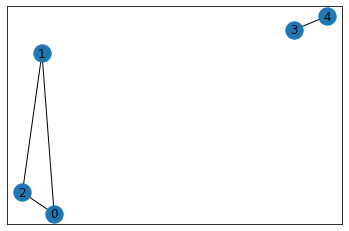

In [3]:
nx.draw_networkx(G)

In [4]:
A = nx.to_numpy_array(G)
print(A)

[[0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 0.]
 [1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


计算一些常用的矩阵：

In [5]:
degs = A.sum(axis=1)
D = np.diag(degs)
D_inv = np.diag([1.0 / d for d in degs])
D_inv_sqrt = np.sqrt(D_inv)

# 3 种拉普拉斯矩阵
L = D - A
L_rw = D_inv @ L
L_sym = D_inv_sqrt @ L @ D_inv_sqrt

以对称归一化的拉普拉斯矩阵特征向量作为基（也可以自己修改，使用别的基试试）：

In [6]:
lambdas, U = np.linalg.eig(L_sym)
print('Frequencies:\n', lambdas)

Frequencies:
 [1.5 0.  1.5 2.  0. ]


设定图上的信号：

In [7]:
np.random.seed(42)
x = np.random.randint(0, 10, 5)
print('Signal(original):\n', x)

Signal(original):
 [6 3 7 4 6]


查看其在频域上的表示：

In [8]:
print('Intensity on different frequencies(original):\n', U.T.dot(x))

Intensity on different frequencies(original):
 [ 0.81649658 -9.23760431  2.20809467 -1.41421356  7.07106781]


使用原始的 $(I+D^{-1/2} A D^{-1/2})x$ 的形式，对应 $(2-\lambda)$ 做滤波函数，相当于 $x$ 与 $(2-\lambda_i) u_i$ 信号做卷积。

In [9]:
h = (2 * np.identity(5) - L_sym).dot(x)
print('Signal(after convolution):\n', h)

Signal(after convolution):
 [11.   9.5 11.5 10.  10. ]


查看卷积结果在频域上的表示：

In [10]:
print('Intensity on different frequencies(after convolution):\n', U.T.dot(h))
print('Product of intensity of original signal and filter:\n', np.multiply(U.T.dot(x), (2-lambdas)))

Intensity on different frequencies(after convolution):
 [  0.40824829 -18.47520861   1.10404734   0.          14.14213562]
Product of intensity of original signal and filter:
 [  0.40824829 -18.47520861   1.10404734  -0.          14.14213562]


可以看到，卷积结果 $h$ 在频域上的分量大小，就是 $x$ 原来分量的大小乘以卷积核分量的大小。

In [11]:
print('Frequencies:\n', lambdas)
print('Intensity on different frequencies(original):\n', U.T.dot(x))
print('Intensity on different frequencies(after convolution):\n', U.T.dot(h))
print('Ratio of intensity:\n', np.divide(U.T.dot(h), U.T.dot(x)))

Frequencies:
 [1.5 0.  1.5 2.  0. ]
Intensity on different frequencies(original):
 [ 0.81649658 -9.23760431  2.20809467 -1.41421356  7.07106781]
Intensity on different frequencies(after convolution):
 [  0.40824829 -18.47520861   1.10404734   0.          14.14213562]
Ratio of intensity:
 [ 0.5  2.   0.5 -0.   2. ]


从各频率上的分量来看，通过卷积后，原来频率为 1.5 的两个分量被抑制了（幅度减小了一半），原来频率为 2 的分量直接滤没了，原来频率为 0 的分量被增强了（幅度增加了一倍），这与滤波函数 $2-\lambda$ 是一致的。

再看下加了自环的情况，也即使用 normalization trick，对应 $(1-\lambda)$ 做滤波函数，相当于 $x$ 与 $(1-\lambda_i) u_i$ 信号做卷积。

In [12]:
A_ = A + np.identity(5)
degs_ = A_.sum(axis=1)
D_ = np.diag(degs_)
D_inv_ = np.diag([1.0 / d for d in degs_])
D_inv_sqrt_ = np.sqrt(D_inv_)

# 3 种拉普拉斯矩阵
L_ = D_ - A_
L_rw_ = D_inv_ @ L_
L_sym_ = D_inv_sqrt_ @ L_ @ D_inv_sqrt_

In [13]:
lambdas_, U_ = np.linalg.eig(L_sym_)
print('Frequencies:\n', lambdas_)

Frequencies:
 [1. 0. 1. 1. 0.]


In [14]:
print('Intensity on different frequencies(original):\n', U_.T.dot(x))

Intensity on different frequencies(original):
 [ 0.81649658 -9.23760431  2.74249553 -1.41421356  7.07106781]


In [15]:
h_ = (np.identity(5) - L_sym_).dot(x)
print('Signal:\n', x)
print('Signal(after convolution):\n', h_)

Signal:
 [6 3 7 4 6]
Signal(after convolution):
 [5.33333333 5.33333333 5.33333333 5.         5.        ]


In [16]:
print('Intensity on different frequencies(after convolution):\n', U_.T.dot(h_))
print('Product of intensity of original signal and filter:\n', np.multiply(U_.T.dot(x), (1-lambdas_)))

Intensity on different frequencies(after convolution):
 [-4.44089210e-16 -9.23760431e+00  4.44089210e-16  0.00000000e+00
  7.07106781e+00]
Product of intensity of original signal and filter:
 [ 0.00000000e+00 -9.23760431e+00  3.04478168e-16  3.14018492e-16
  7.07106781e+00]


In [17]:
print('Frequencies:\n', lambdas_)
print('Intensity on different frequencies(original):\n', U_.T.dot(x))
print('Intensity on different frequencies(after convolution):\n', U_.T.dot(h_))
print('Ratio of intensity:\n', np.divide(U_.T.dot(h_), U_.T.dot(x)))

Frequencies:
 [1. 0. 1. 1. 0.]
Intensity on different frequencies(original):
 [ 0.81649658 -9.23760431  2.74249553 -1.41421356  7.07106781]
Intensity on different frequencies(after convolution):
 [-4.44089210e-16 -9.23760431e+00  4.44089210e-16  0.00000000e+00
  7.07106781e+00]
Ratio of intensity:
 [-5.43895982e-16  1.00000000e+00  1.61928873e-16 -0.00000000e+00
  1.00000000e+00]


可以看到，频率为 1 的分量直接滤没了，频率为 0 的分量保留了下来，这与滤波函数 $1-\lambda$ 是一致的。

## 总结
| | 传统信号处理 | 图信号处理 |
|--|--|--|
| 信号 | $\{x(t)\}_{t=0}^{+\infty}$ | $x \in \mathbb{R}^{n}$ |
| 基 | 傅里叶基（正余弦信号）| 拉普拉斯矩阵基 |
| 频率 | 正余弦信号的频率 | 拉普拉斯矩阵的特征值 |

两个信号的卷积操作，其实是把频域上的分量系数相乘。类比传统时域上的信号处理，图信号处理使用拉普拉斯矩阵的特征向量作为基，得到信号在频域上的表示。

通过对 GCN 公式的分析，我们可以知道 GCN 中的卷积对各频率的分量有什么影响，从谱域(sepctral domain)对 GCN 进行了另一个角度的认识。与 CNN 不同，GCN 中的卷积信号不是学出来的，而是采用拉普拉斯矩阵的特征向量的线性组合（即 $\sum_{i=1}^{n} (1-\lambda_i) u_i$），其中包含了图结构的信息，再与图属性 $x$ 做卷积，同时使用了结构和属性。

## References
\[1\]WU F, SOUZA A, ZHANG T, 等. Simplifying Graph Convolutional Networks\[C/OL\]//International Conference on Machine Learning. PMLR, 2019: 6861–6871.

\[2\]QIMAI LI, ZHICHAO HAN, XIAO-MING WU. Deeper Insights Into Graph Convolutional Networks for Semi-Supervised Learning\[J/OL\]. AAAI Conference on Artificial Intelligence; Thirty-Second AAAI Conference on Artificial Intelligence, 2018.

\[3\]NT H, MAEHARA T. Revisiting Graph Neural Networks: All We Have is Low-Pass Filters\[J/OL\]. arXiv:1905.09550, 2019.
